# IMAGEN - ERROR ANALYSIS
The preliminary results in our IMAGEN paper advocates for a more in-depth understanding of what contributes to the significant performance of the ML models for the three time-points: <br>
<li>Baseline (<b>BL</b>): Age <tr> <b>14</b></li>
<li>Follow 1 year (<b>FU1</b>): Age <b>16</b></li>
<li>Follow 2 year (<b>FU2</b>): Age <b>19</b></li>
<li>Follow 3 year (<b>FU3</b>): Age <b>22</b></li>

Such in-depth understanding can be achieved by performing follow-up analysis such as: <br>

## Overview


## Error Analysis

In [1]:
################################################################################
""" IMAGEN - ERROR ANALYSIS """
# Author : JiHoon Kim, <jihoon.kim@fu-berlin.de>, 8th September 2021
#
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np
from glob import glob
from os.path import join 
import os 
from scikits.bootstrap import ci
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from plotResults import *

### 1. Visualization

#### 1.1 probabilitiy distributions

In [2]:
df = pd.read_csv(sorted(glob("results/newlbls-fu3-espad-fu3-19a-binge-*/*/run.csv"))[-1])

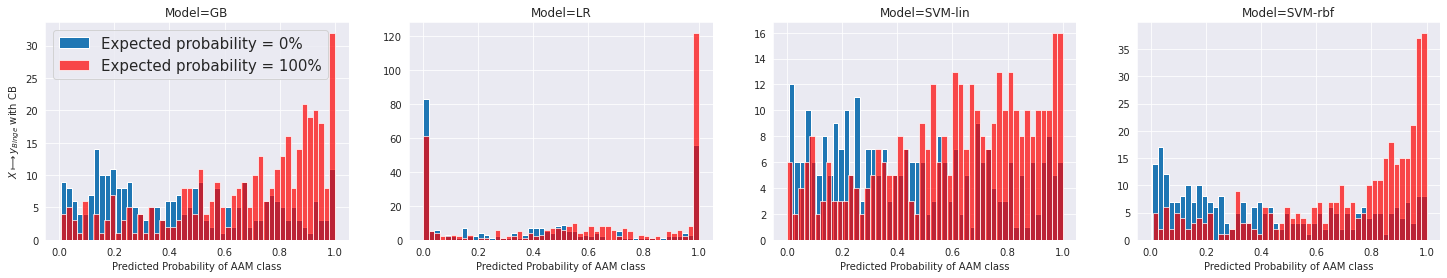

In [3]:
grp_order = ["io", "technique", "model"]
groups = df.groupby(grp_order)   
n_models = len(df["model"].unique())
n_rows = round(len(groups)/n_models)
fig, axes = plt.subplots(n_rows, n_models, 
                         sharex=True, sharey=False,
                         figsize=(25, n_models*n_rows))
axes = np.ravel(axes)
        
for i, (g, dfi) in enumerate(groups):
    ids_all = np.array([id_lists for ids in dfi["test_ids"] for id_lists in eval(ids)])
    assert ids_all.shape[0] == np.unique(ids_all).shape[0]
    probs_all = np.array([prob_lists for probs in dfi["test_probs"] for prob_lists in eval(probs)])
    y_all = np.array([y_lists for y in dfi["test_lbls"] for y_lists in eval(y)])
    assert probs_all.shape[0] == y_all.shape[0]

    prediction=probs_all[:,1]
    ax = axes[i]
    ax.hist(prediction[y_all==0], bins=50, label='Expected probability = 0%')
    ax.hist(prediction[y_all==1], bins=50, label='Expected probability = 100%', alpha=0.7, color='r')
    ax.set_xlabel('Predicted Probability of AAM class')
    if i%n_models == 0:
        ax.set_ylabel("{} with {}".format(remap_io(dfi.iloc[0]), g[1].upper()))
    if i == 0:
        ax.legend(fontsize=15)
    ax.set_title("Model={}".format(g[-1]))
    
plt.show()

### 2. Performance across sites

#### 2.1 main experiment

In [65]:
df = pd.read_csv(sorted(glob("results/newlbls-fu3-espad-fu3-19a-binge-*/*/run.csv"))[-1])

In [66]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from itertools import chain, repeat

test_id = sum([df['test_ids'][i].strip('][').split(', ') for i in range(28)], [])
test_probs = np.array([prob_lists for probs in df["test_probs"] for prob_lists in eval(probs)])[:,1]
test_lbls = sum([df['test_lbls'][i].strip('][').split(', ') for i in range(28)], [])
model = [g for (g, dfi) in df.groupby(["i", "o", "technique", "model"])]
test_model = list(chain.from_iterable((repeat(number, 650) for number in model)))

df2 = pd.DataFrame({
    "ID" : test_id,
    "Model" : test_model,
    "Probability" : test_probs, 
    "Labels" : test_lbls,})
DF = df2.astype({"ID":'int', "Probability":'float', "Labels":'float'})

TP = (DF.Labels == 1.0) & (DF.Probability >= 0.5)
TN = (DF.Labels == 0.0) & (DF.Probability <= 0.5)
FP = (DF.Labels == 0.0) & (DF.Probability >= 0.5)
FN = (DF.Labels == 1.0) & (DF.Probability <= 0.5)

DF['TP'] = DF[TP]['Probability']
DF['TN'] = DF[TN]['Probability']
DF['FP'] = DF[FP]['Probability']
DF['FN'] = DF[FN]['Probability']
DF['T'] = DF[TP | TN]['Probability']
DF['F'] = DF[FP | FN]['Probability']

DF.to_csv('newlbls-fu3-espad-fu3-19a-binge-n650_run.csv', index=False)

In [67]:
# DF = pd.read_csv('newlbls-fu3-espad-fu3-19a-binge-n650_run.csv')
models = DF.groupby(['Model']) 

for i, (g, dfi) in enumerate(models):
    y_true = dfi['Labels'].to_list()
    y_pred = np.round(dfi['Probability'].to_list())
    # classification report
    print(f"Classification report {dfi['Model'].iloc[0]} \n"
          f"{classification_report(y_true, y_pred, target_names=['HC', 'AAM'])}")
#     # Confusion Matrix
#     print(f'confusion matrix \n {confusion_matrix(y_true, y_pred)} \n'
#     # Accuracy
#           f'accruacy score \n {accuracy_score(y_true, y_pred)} \n'
#     # Recall
#           f'recall score \n {recall_score(y_true, y_pred, average=None)} \n'
#     # Precision
#           f'precision score \n {precision_score(y_true, y_pred, average=None)} \n'
#     # f1 Score
#           f'f1_score \n {f1_score(y_true, y_pred, average=None)}')

Classification report ('X', 'Binge', 'cb', 'GB') 
              precision    recall  f1-score   support

          HC       0.67      0.60      0.63       282
         AAM       0.72      0.77      0.74       368

    accuracy                           0.70       650
   macro avg       0.69      0.69      0.69       650
weighted avg       0.69      0.70      0.69       650

Classification report ('X', 'Binge', 'cb', 'LR') 
              precision    recall  f1-score   support

          HC       0.56      0.60      0.58       282
         AAM       0.68      0.64      0.66       368

    accuracy                           0.62       650
   macro avg       0.62      0.62      0.62       650
weighted avg       0.63      0.62      0.63       650

Classification report ('X', 'Binge', 'cb', 'SVM-lin') 
              precision    recall  f1-score   support

          HC       0.58      0.59      0.59       282
         AAM       0.68      0.67      0.68       368

    accuracy               

In [68]:
################################################################################
from imagen_instrumentloader import *
from imagen_plot_statistics import *
# DATA_DIR = '/ritter/share/data/IMAGEN'

In [69]:
import joypy
%matplotlib inline

In [78]:
DF = pd.read_csv('newlbls-fu3-espad-fu3-19a-binge-n650_run.csv')

In [79]:
binge_ML = DF.groupby('Model')
binge_ML_GB = binge_ML.get_group("('X', 'Binge', 'cb', 'GB')")
binge_ML_LR = binge_ML.get_group("('X', 'Binge', 'cb', 'LR')")
binge_ML_SVM_lin = binge_ML.get_group("('X', 'Binge', 'cb', 'SVM-lin')")
binge_ML_SVM_rbf = binge_ML.get_group("('X', 'Binge', 'cb', 'SVM-rbf')")

In [94]:
binge_ML_GB_T = binge_ML_GB[['ID','T']].dropna(axis=0)

In [100]:
GB_T = binge_ML_GB_T['ID'].values.tolist()

In [96]:
binge_ML_GB_F = binge_ML_GB[['ID','F']].dropna(axis=0)

In [101]:
GB_F = binge_ML_GB_F['ID'].values.tolist()

### CTQ

In [30]:
CTQ = IMAGEN_instrument()
binge_CTQ = CTQ.read_instrument(
    'newlbls-fu3-espad-fu3-19a-binge-n650_CTQ.csv'
)
col_binge_CTQ = binge_CTQ.columns[:-6]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=2.622e-01 stat=-1.123e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=5.090e-02 stat=-1.959e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=6.371e-01 stat=-4.722e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with

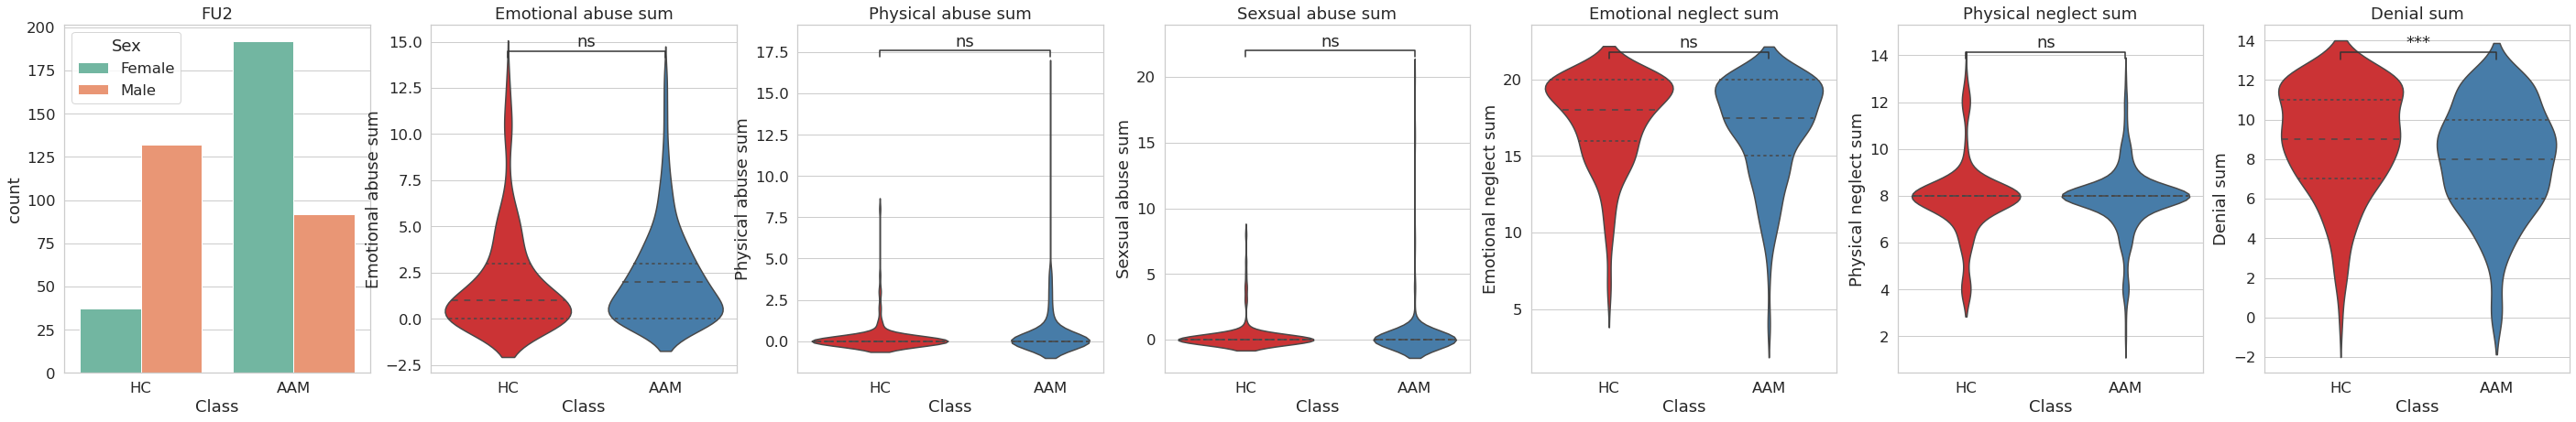

In [105]:
DF = binge_CTQ.set_index('ID').loc[GB_T, :]
COL = col_binge_CTQ

for (S, DF) in [('FU2', DF)]:
    columns = col_binge_CTQ
    sns.set(style="whitegrid", font_scale=1.5)
    fig, axes = plt.subplots(nrows=1, ncols=len(columns)+1,
                             figsize=((len(columns)+1)**2, len(columns)+1))
    sns.countplot(x="Class", hue='Sex', order=['HC', 'AAM'], data = DF,
                  ax = axes[0], palette="Set2").set(title=S)
    
    for i, j in enumerate(columns):
        axes[i+1].set_title(columns[i])
        sns.violinplot(x="Class", y=j, data=DF, order=['HC', 'AAM'],
                       inner="quartile", ax = axes[i+1], palette="Set1")
        add_stat_annotation(ax = axes[i+1], data=DF, x="Class", y=j,
                            box_pairs = [("HC","AAM")], order=["HC","AAM"],
                            test='t-test_ind', text_format='star', loc='inside') 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=4.628e-01 stat=-7.361e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=9.771e-01 stat=2.872e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with Bonferroni correction, P_val=8.451e-03 stat=-2.668e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. AAM: t-test independent samples with 

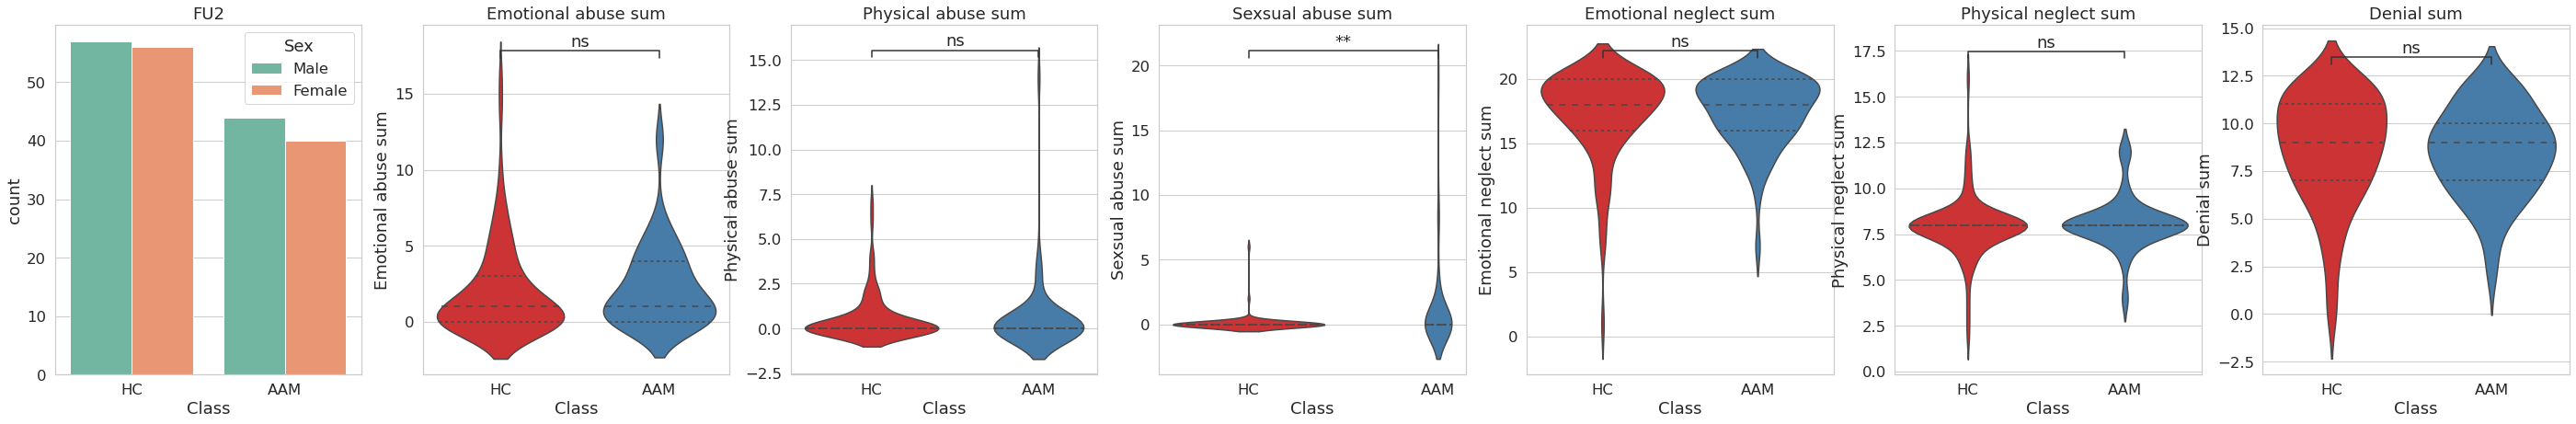

In [106]:
DF = binge_CTQ.set_index('ID').loc[GB_F, :]
COL = col_binge_CTQ

for (S, DF) in [('FU2', DF)]:
    columns = col_binge_CTQ
    sns.set(style="whitegrid", font_scale=1.5)
    fig, axes = plt.subplots(nrows=1, ncols=len(columns)+1,
                             figsize=((len(columns)+1)**2, len(columns)+1))
    sns.countplot(x="Class", hue='Sex', order=['HC', 'AAM'], data = DF,
                  ax = axes[0], palette="Set2").set(title=S)
    
    for i, j in enumerate(columns):
        axes[i+1].set_title(columns[i])
        sns.violinplot(x="Class", y=j, data=DF, order=['HC', 'AAM'],
                       inner="quartile", ax = axes[i+1], palette="Set1")
        add_stat_annotation(ax = axes[i+1], data=DF, x="Class", y=j,
                            box_pairs = [("HC","AAM")], order=["HC","AAM"],
                            test='t-test_ind', text_format='star', loc='inside') 

In [ ]:
plot_binge_FU3_NEO = IMAGEN_descriptive(DF, COL)
plot_binge_FU3_NEO.violinplot()
fig, axes = joypy.joyplot(DF, by='Class', fill=False, figsize = (20, 8), legend=True)
# Normality Test and Independent T test
from scipy.stats import shapiro, levene, ttest_ind, bartlett
for mean in COL[:-3]:
    print("-"*10, mean)
    myAAM = list(DF[DF['Class'] == 'AAM'][mean].values)
    AAM = [x for x in myAAM if pd.isnull(x) == False]
    myHC = list(DF[DF['Class'] == 'HC'][mean].values)    
    HC = [x for x in myHC if pd.isnull(x) == False]
    
    # Shapiro-Wilks
    normal1 = shapiro(AAM)
    normal2 = shapiro(HC)
    print(normal1, normal2)
    # Levene test
    print(levene(AAM, HC))
    # bartlett test
    print(bartlett(AAM, HC))
    # ttest
    print(ttest_ind(AAM, HC))
    print(ttest_ind(AAM, HC, equal_var=False))

---------- Neuroticism mean
ShapiroResult(statistic=0.9592629075050354, pvalue=0.010706119239330292) ShapiroResult(statistic=0.9835637807846069, pvalue=0.20009829103946686)
LeveneResult(statistic=0.2930774531598118, pvalue=0.5888927029411268)
BartlettResult(statistic=0.5165348853497952, pvalue=0.4723235558468528)
Ttest_indResult(statistic=-0.030111910256525962, pvalue=0.9760095754426766)
Ttest_indResult(statistic=-0.03043482885117567, pvalue=0.9757538256821212)
---------- Extroversion mean
ShapiroResult(statistic=0.9773122668266296, pvalue=0.1547238528728485) ShapiroResult(statistic=0.985163152217865, pvalue=0.2699050009250641)
LeveneResult(statistic=5.021840822415453, pvalue=0.026193240424984138)
BartlettResult(statistic=2.5301004230712967, pvalue=0.11169310766243143)
Ttest_indResult(statistic=2.8014401268421265, pvalue=0.005616971657788047)
Ttest_indResult(statistic=2.8682825349967223, pvalue=0.004603084236064896)
---------- Openness mean
ShapiroResult(statistic=0.9772196412086487, p

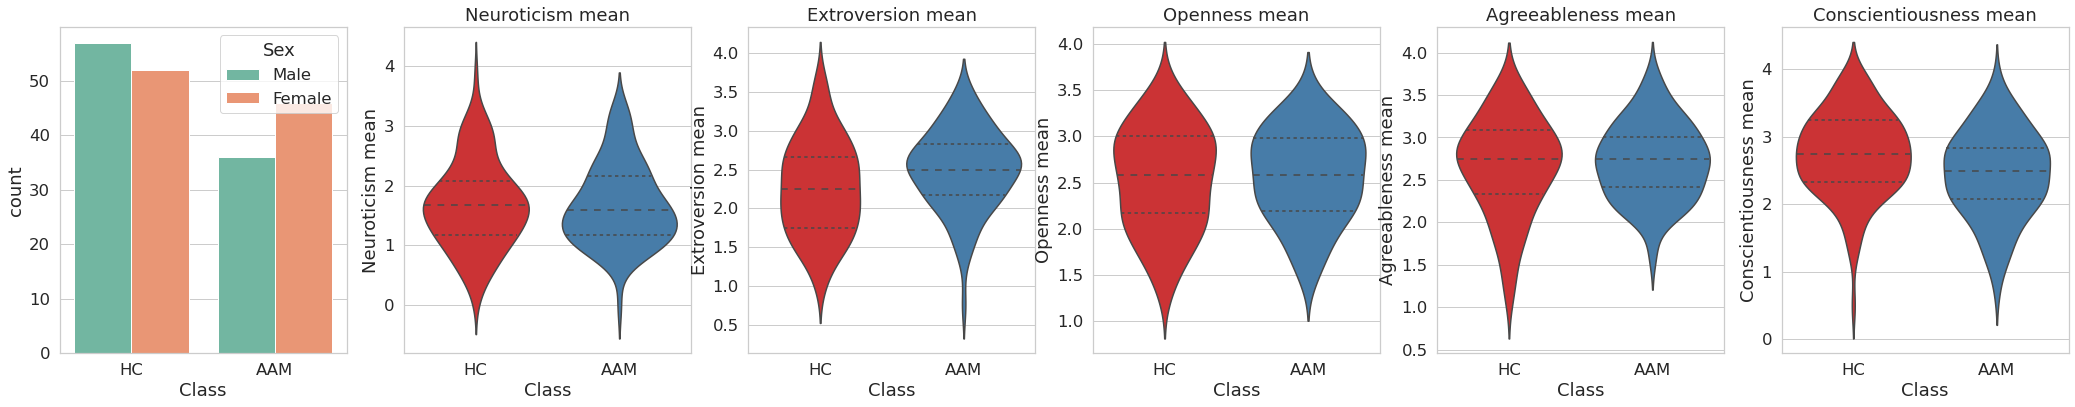

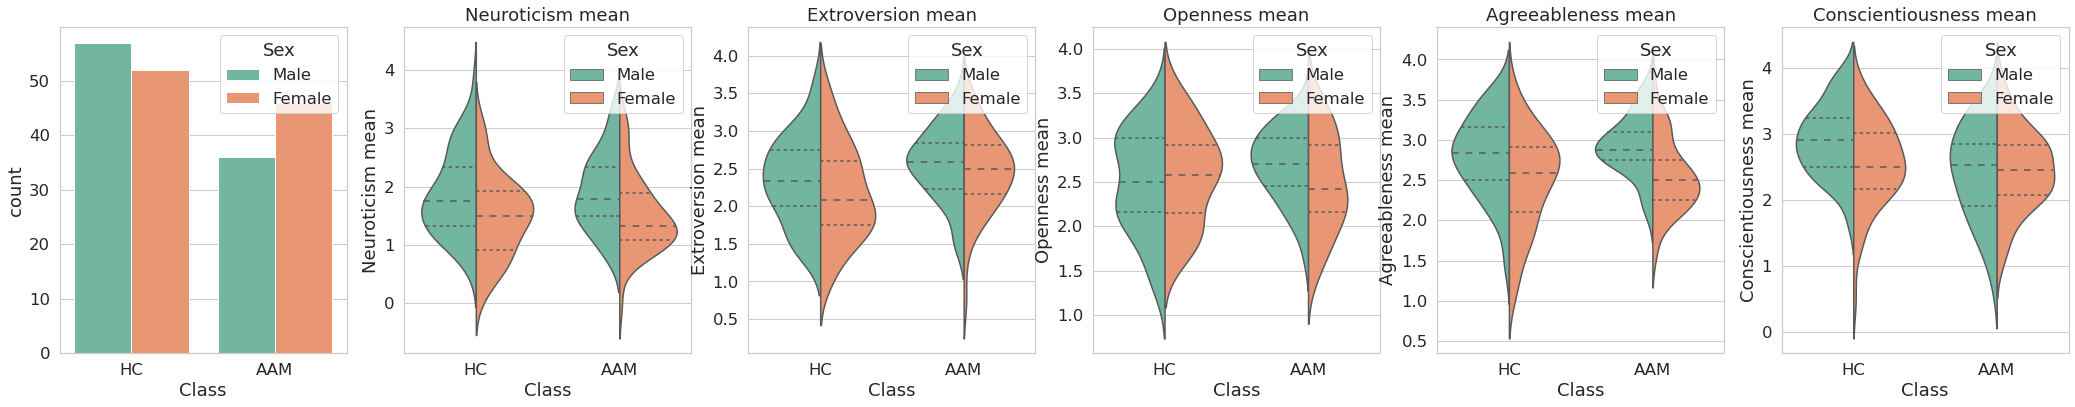

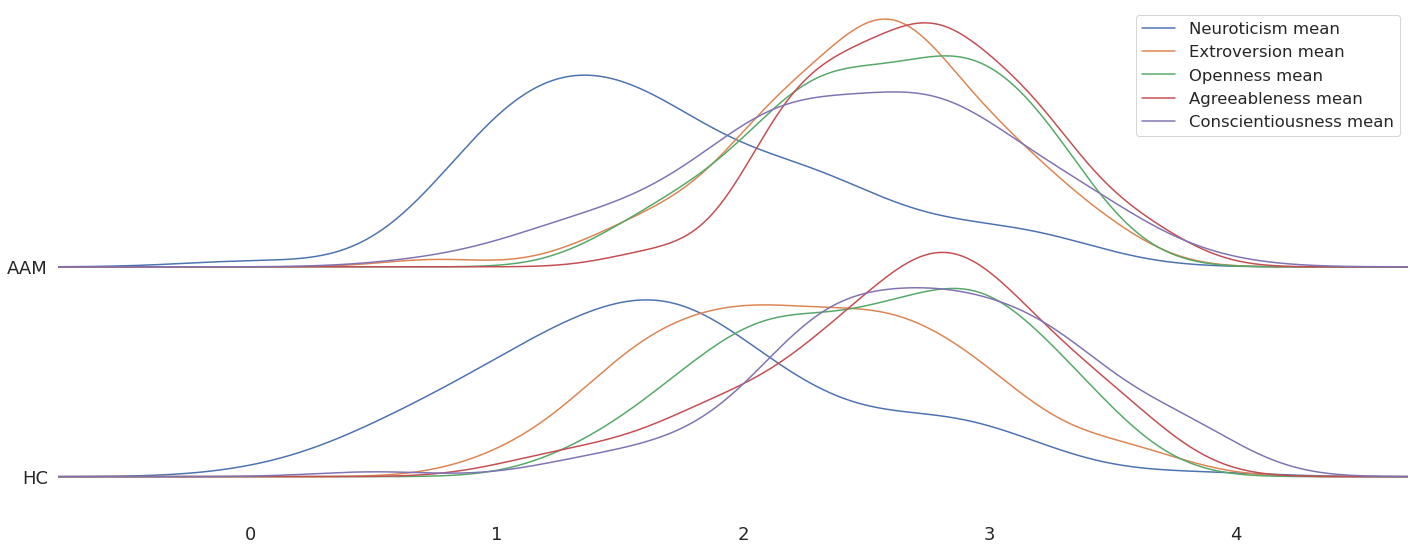

In [35]:
DF = df_binge_FU3_NEO.loc[df_F['ID'].to_list(), :]
COL = col_binge_FU3_NEO

plot_binge_FU3_NEO = IMAGEN_descriptive(DF, COL)
plot_binge_FU3_NEO.violinplot()
fig, axes = joypy.joyplot(DF, by='Class', fill=False, figsize = (20, 8), legend=True)
# Normality Test and Independent T test
from scipy.stats import shapiro, levene, ttest_ind, bartlett
for mean in COL[:-3]:
    print("-"*10, mean)
    myAAM = list(DF[DF['Class'] == 'AAM'][mean].values)
    AAM = [x for x in myAAM if pd.isnull(x) == False]
    myHC = list(DF[DF['Class'] == 'HC'][mean].values)    
    HC = [x for x in myHC if pd.isnull(x) == False]
    
    # Shapiro-Wilks
    normal1 = shapiro(AAM)
    normal2 = shapiro(HC)
    print(normal1, normal2)
    # Levene test
    print(levene(AAM, HC))
    # bartlett test
    print(bartlett(AAM, HC))
    # ttest
    print(ttest_ind(AAM, HC))
    print(ttest_ind(AAM, HC, equal_var=False))